# Training a multi-layer perceptron (MLP) on MNIST Kaggle challenge

In [1]:
%matplotlib inline

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.cm as CM

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SequentialSampler

In [2]:
train_file = 'train.csv'
test_file = 'test.csv'
output_file = 'submission.csv'


# set random seed
torch.manual_seed(1122)

# load data
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
test_data = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')

# create np matrices
x_train, x_val, y_train, y_val = train_test_split(
    raw_data[:, 1:], raw_data[:, 0], test_size=0.001)
x_test, y_test = test_data[:, :], np.zeros((test_data.shape[0], 1))

# normalize training data
x_train = normalize(x_train, norm='max', axis=1)
x_val = normalize(x_val, norm='max', axis=1)
x_test = normalize(x_test, norm='max', axis=1)

# create pytorch compatible dataset that has API for automated loaders
trainset = TensorDataset(torch.Tensor(x_train.tolist()).view(-1, 1, 28, 28),
                         torch.Tensor(y_train.tolist()).long())

valset = TensorDataset(torch.Tensor(x_val.tolist()).view(-1, 1, 28, 28),
                       torch.Tensor(y_val.tolist()).long())

testset = TensorDataset(torch.Tensor(x_test.tolist()).view(-1, 1, 28, 28),
                        torch.Tensor(y_test.tolist()).long())

# create pytorch mini-batch loader DataLoader for the dataset
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

valloader = DataLoader(valset, batch_size=250, shuffle=True)

# for test set, we want to maintain the sequence of the data
testsampler = SequentialSampler(testset)
testloader = DataLoader(testset, batch_size=100, shuffle=False,
                        sampler=testsampler)

In [3]:

# define and initialize a multilayer-perceptron, a criterion, and an optimizer
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(1 * 28 * 28, 20)
        self.t1 = nn.Tanh()
        self.l2 = nn.Linear(20, 10)
        self.t2 = nn.LogSoftmax()

    def forward(self, x):
        x = x.view(-1, 1*28*28)
        x = self.t1(self.l1(x))
        x = self.t2(self.l2(x))
        return x

mlp = MLP()
criterion = nn.NLLLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.1, momentum=0.9)

In [4]:
print(mlp)
print(criterion)
print(optimizer)

MLP (
  (l1): Linear (784 -> 20)
  (t1): Tanh ()
  (l2): Linear (20 -> 10)
  (t2): LogSoftmax ()
)
NLLLoss (
)


In [7]:
# define a training epoch function
def trainEpoch(dataloader, epoch):
    print("Training Epoch %i" % (epoch + 1))
    mlp.train()
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


def validateModel(dataloader, epoch):
    mlp.eval()
    test_loss = 0
    correct = 0
    pred = np.array([])
    targ = np.array([])
    for inputs, targets in dataloader:
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = mlp(inputs)
        test_loss += F.nll_loss(outputs, targets, size_average=False).data[0]
        pred = np.append(pred, outputs.topk(1)[1].data.view(1, -1).numpy())
        targ = np.append(targ, targets.data.numpy())
        prd = outputs.topk(1)[1].data
        correct += prd.eq(targets.data.view_as(prd)).sum()
    test_loss /= len(dataloader.dataset)
    test_acc = correct / len(dataloader.dataset)
    cm = confusion_matrix(targ, pred)
    print('[Epoch %i] Accuracy: %.2f, Average Loss: %.2f' %
          (epoch, test_acc, test_loss))
    return test_loss, test_acc, cm


def testModel(dataloader):
    mlp.eval()
    pred = np.array([])
    for inputs, _ in dataloader:
        inputs = Variable(inputs)
        outputs = mlp(inputs)
        pred = np.append(pred, outputs.topk(1)[1].data.view(1, -1).numpy())
    return pred

In [8]:
# run the training epoch 100 times and test the result

epoch_loss = []
epoch_acc = []
for epoch in range(30):
    trainEpoch(trainloader, epoch)
    loss, acc, _ = validateModel(valloader, epoch)
    epoch_loss.append(loss)
    epoch_acc.append(acc)

Training Epoch 1
[Epoch 0] Accuracy: 0.93, Average Loss: 0.59
Training Epoch 2
[Epoch 1] Accuracy: 0.90, Average Loss: 0.30
Training Epoch 3
[Epoch 2] Accuracy: 0.90, Average Loss: 0.44
Training Epoch 4
[Epoch 3] Accuracy: 0.90, Average Loss: 0.39
Training Epoch 5
[Epoch 4] Accuracy: 0.90, Average Loss: 0.61
Training Epoch 6
[Epoch 5] Accuracy: 0.90, Average Loss: 0.57
Training Epoch 7
[Epoch 6] Accuracy: 0.90, Average Loss: 0.58
Training Epoch 8
[Epoch 7] Accuracy: 0.90, Average Loss: 0.52
Training Epoch 9
[Epoch 8] Accuracy: 0.90, Average Loss: 0.56
Training Epoch 10
[Epoch 9] Accuracy: 0.93, Average Loss: 0.40
Training Epoch 11
[Epoch 10] Accuracy: 0.90, Average Loss: 0.43
Training Epoch 12
[Epoch 11] Accuracy: 0.90, Average Loss: 0.51
Training Epoch 13
[Epoch 12] Accuracy: 0.93, Average Loss: 0.49
Training Epoch 14
[Epoch 13] Accuracy: 0.93, Average Loss: 0.42
Training Epoch 15
[Epoch 14] Accuracy: 0.93, Average Loss: 0.40
Training Epoch 16
[Epoch 15] Accuracy: 0.90, Average Loss: 

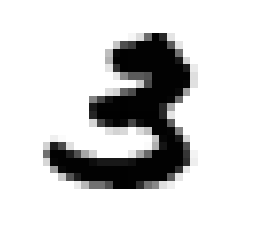

3.0


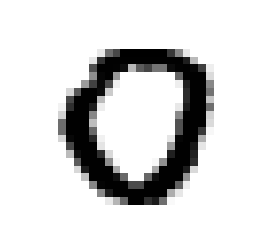

0.0


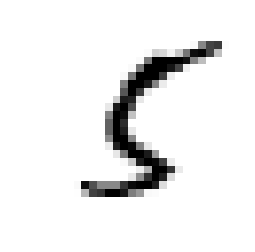

5.0


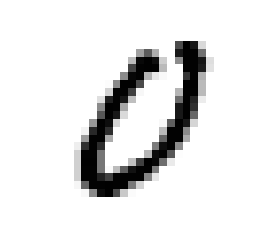

0.0


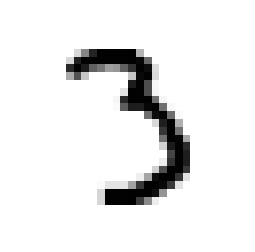

3.0


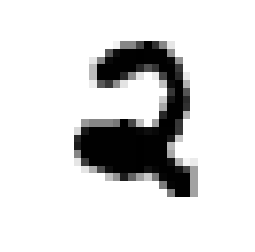

2.0


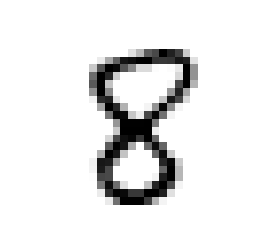

8.0


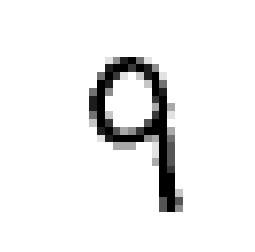

9.0


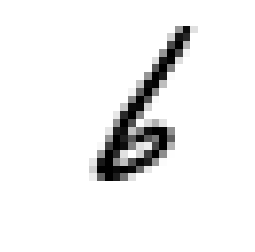

6.0


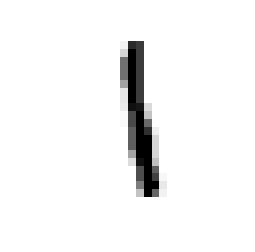

1.0


In [9]:
pred = testModel(testloader)
# check the actual image for confirmation
def display(img):
    one_image = img.reshape(28, 28)
    plt.axis('off')
    plt.imshow(one_image, cmap=CM.binary)

for idx in torch.randperm(len(pred))[:10]:
    display(test_data[idx])
    plt.show()
    print(pred[idx])